In [1]:
!nvidia-smi

Mon May 30 09:33:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P0    N/A /  N/A |     75MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Cài đặt các thư viện cần thiết


In [22]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

### Load input ảnh gốc và ảnh mask


(-0.5, 1499.5, 707.5, -0.5)

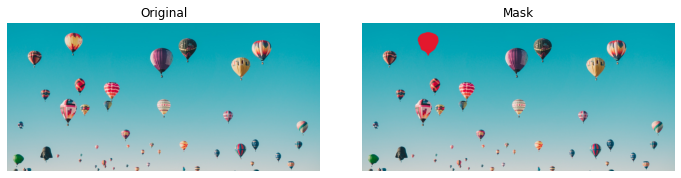

In [23]:
original_pic = Image.open("input.png")
mask_pic = Image.open("mask.png")

original = np.asarray(original_pic)
mask = np.asarray(mask_pic)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.tight_layout()
ax[0].imshow(original)
ax[0].set_title("Original")
ax[0].axis("off")
ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[1].axis("off")

### Tính ảnh xám và lọc ảnh mask

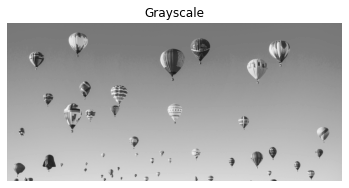

In [24]:
# Tính ảnh xám từ ảnh gốc
grayscale_pic = original_pic.convert("L")
grayscale = np.asarray(grayscale_pic)

plt.imshow(grayscale, cmap="gray")
plt.title("Grayscale")
plt.axis("off")
plt.imsave("grayscale.png", grayscale, cmap="gray")

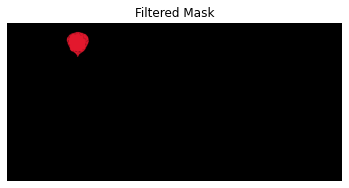

In [25]:
# Lọc ảnh mask làm đen đi các phần không phải mask
def check_color_mask(color):
    return ((color[0] >= 0 and color[1] >= 180 and color[2] <= 75) or    # green 
            (color[0] >= 227 and color[1] <= 24 and color[2] <= 45))    # red

def filter_mask(_mask):
    pic = _mask.astype('float32')
    width = pic.shape[1]
    height = pic.shape[0]
    new_mask = [[0 for _ in range(width)] for _ in range(height)]
    for i in range(height):
        for j in range(width):
            if check_color_mask(pic[i][j]):
                new_mask[i][j] = pic[i][j] # giữ nguyên màu
            else:
                new_mask[i][j] = np.asarray([0, 0, 0, 255]) # đổi màu đen

    return np.asarray(new_mask).astype('uint8')

mask = filter_mask(mask)
plt.imshow(mask)
plt.title("Filtered Mask")
plt.axis("off")
plt.imsave("filtered_mask.png", mask)

### Xây dựng hàm tính Energy Map cho ảnh

Ở đây còn xét thêm yếu tố mask để tính toán giá trị mới cho energy. Để đơn giản em xét 3 trường hợp của mp (mask_point) như sau:
- mp = 1 khi có pixel ảnh mask màu xanh lá cây (giữ lại pixel)
- mp = -1 khi có pixel ảnh mask màu đỏ (ưu tiên xóa)
- mp = 0 khi có pixel ảnh mask màu đen (để như cũ)

Vây nên công thức để tính energy của từng điểm ảnh như sau

$$
dx = I(i, j + 1) - I(i, j - 1) \\
dy = I(i + 1, j) - I(i -1, j) \\
E = \left\{\begin{matrix}
255 & ,mp = 1 \\ 
0   & ,mp = -1 \\ 
\sqrt{dx^2 + dy^2} & ,mp = 0 
\end{matrix}\right.
$$

In [26]:
def get_mask_point(color):
  if color[0] >= 0 and color[1] >= 180 and color[2] <= 75:  # green
    return 1
  elif color[0] >= 227 and color[1] <= 24 and color[2] <= 45:  # red
    return -1
  else:
    return 0

In [27]:
infinity = 10000
def calculate_energy_map(img, mask):
    pic = img.astype("float32")
    width = pic.shape[1]
    height = pic.shape[0]
    energy_map = [[0 for _ in range(width)] for _ in range(height)]

    # tính energy của từng pixel
    for i in range(0, height):
        for j in range(0, width):
            mp = get_mask_point(mask[i][j])

            if mp == 1:
                energy_map[i][j] = infinity
            elif mp == -1:
                energy_map[i][j] = -infinity
            else:   # not mask pixel
                dx = (0 if j == width - 1 else pic[i, j + 1]) - (0 if j == 0 else pic[i, j - 1])
                dy = (0 if i == height - 1 else pic[i + 1, j]) - (0 if i == 0 else pic[i - 1, j])
                energy_map[i][j] = math.sqrt(dx**2 + dy**2)

    return np.asarray(energy_map).astype("float32")

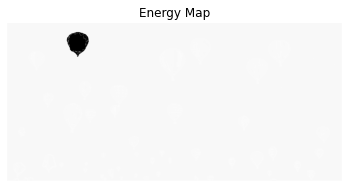

In [28]:
# In ảnh energy map
energy_map = calculate_energy_map(grayscale, mask)
plt.imshow(energy_map, cmap="gray")
plt.title("Energy Map")
plt.axis("off")
plt.imsave("energymap.png", energy_map, cmap="gray")

### Xây dựng bảng tính tích lũy Energy Map
Ở đây, dựa vào bảng Energy Map được tính ở trên, ta sẽ tạo ra một bảng với các phần tử là 1 tuple chứa 2 trường là (tổng energy tới ô đang xét, parent của ô đang xét).
- Tổng energy tới 1 ô được tính từ các parent trên đó và tính lên tiếp (dùng quy hoạch động)
- Parent của ô đang xét gồm có 3 hướng:
    + l - vị trí trái trên: ứng với -1
    + m - vị trí ở ngay chính phía trên: ứng với 0
    + r - vị trí phải trên: ứng với 1

In [29]:
# Tìm ra parent tốt nhất của 1 ô
def get_optimize_parent(dp, i, j, width):
    l = math.inf if j == 0 else dp[i - 1][j - 1][0]
    m = dp[i - 1][j][0]
    r = math.inf if j == width - 1 else dp[i - 1][j + 1][0]

    min_parent_node = min(l, m, r)
    if min_parent_node == l:
        return -1
    if min_parent_node == m:
        return 0
    return 1

In [30]:
# Tính bảng tích lũy energy map
def get_accumulation_energy_map(energy_map):
    width = energy_map.shape[1]
    height = energy_map.shape[0]

    # dp là bảng tính tích lũy energy map
    dp = [[(math.inf, 0) for _ in range(width)] for _ in range(height)]

    # khởi tạo dòng đầu của bảng tính tích lũy
    for i in range(0, width):
        dp[0][i] = (energy_map[0, i], 0)

    # quy hoạch động tính ra bảng tích lũy
    for i in range(1, height):
        for j in range(0, width):
            parent = get_optimize_parent(dp, i, j, width)
            dp[i][j] = (energy_map[i, j] + dp[i - 1][j + parent][0], parent)

    return dp

### Xây dựng hàm tìm ra tất cả các đường Seam trong ảnh
Hàm get_all_seams() trả về một mảng các đường Seam trong bức ảnh dựa vào bảng tích lũy Energy Map, trong đó các phần tử là một cặp tuple gồm đường Seam đó và tổng energy của chính đường Seam đó

Seam ở đây là một mảng các pixel với kích thước bằng height, các phần tử trong Seam là cột của pixel thuộc Seam đó tại hàng tương ứng

In [31]:
def get_all_seams(dp):
    seam_list = []  # mỗi phần tử là tuple (Seam, tổng energy của nó)
    width = len(dp[0])
    height = len(dp)
    for i in range(0, width):
        # Tìm ra Seam tương ứng
        current = [0 for _ in range(height)]
        current[height - 1] = i
        for j in reversed(range(height - 1)):
            # vị trí pixel ở hàng đang xét = vị trí pixel được thêm trước đó + parent của nó
            current[j] = current[j + 1] + dp[j + 1][current[j + 1]][1]
        seam_list.append((current, dp[height - 1][i][0]))

    return seam_list


### Xây dựng hàm tìm ra đường Seam có energy nhỏ nhất

Ta sẽ tìm ra đường Seam có energy nhỏ nhất dựa vào dòng các pixel trên cùng, từ đó tìm ra min trong tập các pixel có tồn tại children

In [32]:
def get_least_energy_seam(all_seams, index):
    is_has_child = False
    min_child = 0
    for i in range(1, len(all_seams)):
        if all_seams[i][0][0] == index:  # pixel vị trí xuất phát của seam = index -> có tồn tại child
            is_has_child = True
            if all_seams[i][1] < all_seams[min_child][1]:
                min_child = i

    return all_seams[min_child][0] if is_has_child else None


### Minh họa các đường Seam trong bức ảnh hiện tại

In [33]:
def demo_seams(img, all_seams):
    pic = img.astype("uint8")
    for i in range(len(all_seams)):
        current = all_seams[i][0]
        for j in range(len(current)):
            pic[j][current[j]] = (255, 0, 0)

    return pic

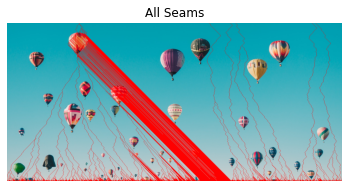

In [34]:
# in ra tất cả các đường Seam ban đầu của ảnh
dp = get_accumulation_energy_map(energy_map)
all_seams = get_all_seams(dp)

all_seams_pic = demo_seams(original, all_seams)

plt.imshow(all_seams_pic)
plt.title("All Seams")
plt.axis("off")
plt.imsave("seams.png", all_seams_pic)

### Tối ưu thuật toán Seam bằng cách xóa nhiều đường Seam cùng lúc
Ở đây, có một đánh giá rằng các đường Seam khác điểm xuất phát (xét từ phía trên) thì sẽ không bao giờ cắt nhau \
Nguồn tham khảo: Fast Video Retargeting Based on Seam Carving with Parental Labeling - Chuning Zhu

Từ đó, ta nhận thấy nếu trong từng lần lặp thay vì xóa một đường Seam có energy thấp nhất và sau đó phải tính toán lại Energy Map từ đầu thì trong chính lần lặp đó ta có thể xóa số lượng đường Seam chính bằng số lượng các pixel trên cùng thuộc tập hợp các Seam tìm được. Lý do chính là vì các đường được chọn sẽ không cắt nhau (theo nhận xét trên) nên energy map sau khi xóa sẽ không ảnh hưởng gì đến các đường Seam khác. 

Như vậy ta có thể xóa cùng lúc nhiều đường Seam mà không sợ ảnh hưởng đến Energy Map trong lần lặp đó

In [35]:
# khởi tạo các ảnh để tính toán
original_scale_down = original.astype("uint8")
grayscale_scale_down = grayscale.astype("uint8")
mask_scale_down = mask.astype("uint8")

scale_width = 1400   # độ rộng mong muốn của ảnh sau khi scale
width = math.inf
count = 1

print("Kết quả các lần lặp hiển thị như sau: (thứ tự lần lặp, width hiện tại)")
while width > scale_width:
    energy_map_data = calculate_energy_map(grayscale_scale_down, mask_scale_down)
    dp = get_accumulation_energy_map(energy_map_data)
    all_seams = get_all_seams(dp)

    width = len(dp[0])
    height = len(dp)
    print(f"({count}, {width}) \t", end="")

    # Tìm các đường Seam cần xóa trong vòng lặp này
    paths_remove = [[] for _ in range(height)]
    for i in range(len(all_seams)):
        seam = get_least_energy_seam(all_seams, i)
        if seam != None:
            for j in range(len(seam)):
                paths_remove[j].append(seam[j])

    # Nếu số lượng đường Seam xóa làm with_scale nhỏ hơn mong muốn thì loại bỏ bớt 1 số đường Seam tại lượt xét đó
    if len(paths_remove[0]) > width - scale_width:
        redundant = len(paths_remove[0]) - (width - scale_width)
        for i in range(len(paths_remove)):
            paths_remove[i] = paths_remove[i][:-redundant]

    new_original = []
    new_grayscale = []
    new_mask = []

    for i in range(len(paths_remove)):
        # scale down ảnh original
        original_paths = [path for path in original_scale_down[i]]
        for j in reversed(paths_remove[i]):
            del original_paths[j]
        new_original.append(np.asarray(original_paths))

        # scale down ảnh grayscale
        grayscale_paths = [path for path in grayscale_scale_down[i]]
        for j in reversed(paths_remove[i]):
            del grayscale_paths[j]
        new_grayscale.append(np.asarray(grayscale_paths))

        # scale down ảnh mask
        mask_paths = [path for path in mask_scale_down[i]]
        for j in reversed(paths_remove[i]):
            del mask_paths[j]
        new_mask.append(np.asarray(mask_paths))

    # cài lại giá trị cho các ảnh sau khi scale
    original_scale_down = np.asarray(new_original)
    grayscale_scale_down = np.asarray(new_grayscale)
    mask_scale_down = np.asarray(new_mask)
    count += 1

Kết quả các lần lặp hiển thị như sau: (thứ tự lần lặp, width hiện tại)
(1, 1500) 	(2, 1494) 	(3, 1488) 	(4, 1482) 	(5, 1476) 	(6, 1469) 	(7, 1463) 	(8, 1457) 	(9, 1451) 	(10, 1444) 	(11, 1438) 	(12, 1431) 	(13, 1425) 	(14, 1418) 	(15, 1412) 	(16, 1406) 	(17, 1400) 	

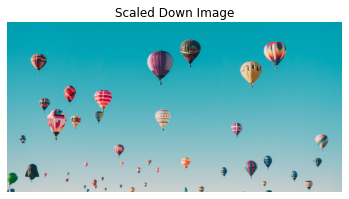

In [36]:
# In ra ảnh sau khi scale down
plt.imshow(original_scale_down, cmap="gray")
plt.title("Scaled Down Image")
plt.axis("off")
plt.imsave("scaled_down_image.png", original_scale_down)

### Tăng kích thước ảnh về kích thước ban đầu

Sau khi xóa xong phần ảnh cần bị xóa, ta đưa ảnh về kích thước ban đầu bằng cách thêm nhiều đường Seam vào ảnh. Các đường Seam này có được bằng cách chọn từ các đường Seam có energy thấp nhất trong Energy Map và nhân đôi đường Seam đó lên sau mỗi vòng lặp.

In [37]:
# khởi tạo các ảnh để tính toán
original_scale_up = original_scale_down.astype("uint8")
grayscale_scale_up = grayscale_scale_down.astype("uint8")
mask_scale_up = mask_scale_down.astype("uint8")

original_width = original.shape[1]   # độ rộng ban đầu trước khi scale
width = original_scale_down.shape[1]
count = 1

print("Kết quả các lần lặp hiển thị như sau: (thứ tự lần lặp, width hiện tại)")
while width < original_width:
    energy_map_data = calculate_energy_map(grayscale_scale_up, mask_scale_up)
    dp = get_accumulation_energy_map(energy_map_data)
    all_seams = get_all_seams(dp)

    width = len(dp[0])
    height = len(dp)
    print(f"({count}, {width}) \t", end="")

    # Tìm các đường Seam cần thêm trong vòng lặp này
    paths_append = [[] for _ in range(height)]
    for i in range(len(all_seams)):
        seam = get_least_energy_seam(all_seams, i)
        if seam != None:
            for j in range(len(seam)):
                paths_append[j].append(seam[j])

    # Nếu số lượng đường Seam thêm vào làm width nhiều hơn mong muốn thì loại bỏ bớt 1 số đường Seam tại lượt xét đó
    if len(paths_append[0]) > original_width - width:
        redundant = len(paths_append[0]) - (original_width - width)
        for i in range(len(paths_append)):
            paths_append[i] = paths_append[i][:-redundant]

    new_original = []
    new_grayscale = []
    new_mask = []
    
    for i in range(len(paths_append)):
        # scale up ảnh original
        original_paths = [path for path in original_scale_up[i]]
        for j in reversed(paths_append[i]):
            original_paths.insert(j + 1, original_paths[j])
        new_original.append(np.asarray(original_paths))

        # scale up ảnh grayscale
        grayscale_paths = [path for path in grayscale_scale_up[i]]
        for j in reversed(paths_append[i]):
            grayscale_paths.insert(j + 1, grayscale_paths[j])
        new_grayscale.append(np.asarray(grayscale_paths))

        # scale up ảnh mask
        mask_paths = [path for path in mask_scale_up[i]]
        for j in reversed(paths_append[i]):
            mask_paths.insert(j + 1, mask_paths[j])
        new_mask.append(np.asarray(mask_paths))

    # cài lại giá trị cho các ảnh sau khi scale
    original_scale_up = np.asarray(new_original)
    grayscale_scale_up = np.asarray(new_grayscale)
    mask_scale_up = np.asarray(new_mask)
    count += 1

Kết quả các lần lặp hiển thị như sau: (thứ tự lần lặp, width hiện tại)
(1, 1400) 	(2, 1406) 	(3, 1412) 	(4, 1418) 	(5, 1424) 	(6, 1430) 	(7, 1436) 	(8, 1442) 	(9, 1448) 	(10, 1455) 	(11, 1462) 	(12, 1469) 	(13, 1476) 	(14, 1483) 	(15, 1490) 	(16, 1497) 	(17, 1500) 	

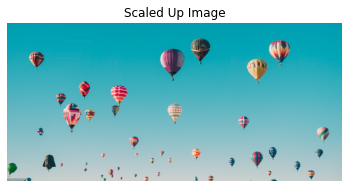

In [38]:
# In ra ảnh sau khi scale up về kích thước ban đầu
plt.imshow(original_scale_up, cmap="gray")
plt.title("Scaled Up Image")
plt.axis("off")
plt.imsave("output.png", original_scale_up)